# Pre trained model 
Para clasificar imágenes, uno de los modelos preentrenados más populares y efectivos es ResNet (Residual Networks), específicamente ResNet50, que es una red profunda muy eficiente para tareas de clasificación de imágenes.

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

Usamos image_dataset_from_directory para cargar las imágenes desde directorios

In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wanderdust/skin-lesion-analysis-toward-melanoma-detection")

print("Path to dataset files:", path)

100%|██████████| 11.3G/11.3G [04:36<00:00, 44.0MB/s]  

Extracting files...


Path to dataset files: C:\Users\marta\.cache\kagglehub\datasets\wanderdust\skin-lesion-analysis-toward-melanoma-detection\versions\1


In [52]:
# Directorios de los datasets
train_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/train'
validation_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/valid'
test_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/test'

# Cargar los datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # Usamos 'int' para obtener etiquetas como enteros
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False  # No barajamos en el conjunto de prueba
)

Found 2000 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


In [53]:
# Obtener las clases en el conjunto de entrenamiento
class_names = train_dataset.class_names  # Accede a los nombres de las clases

# Obtener las etiquetas del dataset
# Esto es una forma de obtener las clases manualmente
labels = []
for images, label_batch in train_dataset:
    labels.extend(label_batch.numpy())

# Calcular los pesos de las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=np.array(labels)  # `y` debe ser un array con las etiquetas
)

# Convertir los pesos a un diccionario
class_weights_dict = dict(zip(np.arange(len(class_names)), class_weights))

# Imprimir los pesos de las clases
print("Pesos de las clases:", class_weights_dict)

Pesos de las clases: {0: 1.7825311942959001, 1: 0.4859086491739553, 2: 2.6246719160104988}


 Cargamos ResNet50 sin la capa final de clasificación (include_top=False), ya que vamos a agregar nuestra propia capa de clasificación según nuestro número de clases.

 ResNet50 requiere que las imágenes sean redimensionadas a 224x224 píxeles y que sus valores estén normalizados de acuerdo con los valores que fueron utilizados para entrenar el modelo preentrenado

In [54]:
# Cargar el modelo preentrenado ResNet50 sin la capa final de clasificación
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Congelar las capas del modelo base

Añadimos una capa densa con 3 unidades y la activación softmax para clasificación multiclase.

In [55]:
# Crear el modelo completo añadiendo capas para la clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Promedio global de las características
    layers.Dense(1024, activation='relu'),  # Capa densa para aprender representaciones
    layers.Dense(len(class_names), activation='softmax')  # 3 clases (salida con softmax)
])

In [56]:
# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo con nuestro conjunto de datos

In [57]:
# Entrenar el modelo usando los pesos de las clases
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    class_weight=class_weights_dict  # Usamos los pesos de clase durante el entrenamiento
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.4640 - loss: 1.9385 - val_accuracy: 0.6067 - val_loss: 0.9053
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6462 - loss: 0.6579 - val_accuracy: 0.6133 - val_loss: 0.8405
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7109 - loss: 0.5800 - val_accuracy: 0.5533 - val_loss: 0.9752
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7457 - loss: 0.5274 - val_accuracy: 0.5733 - val_loss: 0.9380
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7515 - loss: 0.4708 - val_accuracy: 0.6200 - val_loss: 0.7897
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.7693 - loss: 0.4416 - val_accuracy: 0.6533 - val_loss: 0.8669
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8415 - loss: 0.3324 - val_accuracy: 0.7400 - val_loss: 0.7703
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8696 - loss: 0.2709 - val_accuracy: 0.6733 - v

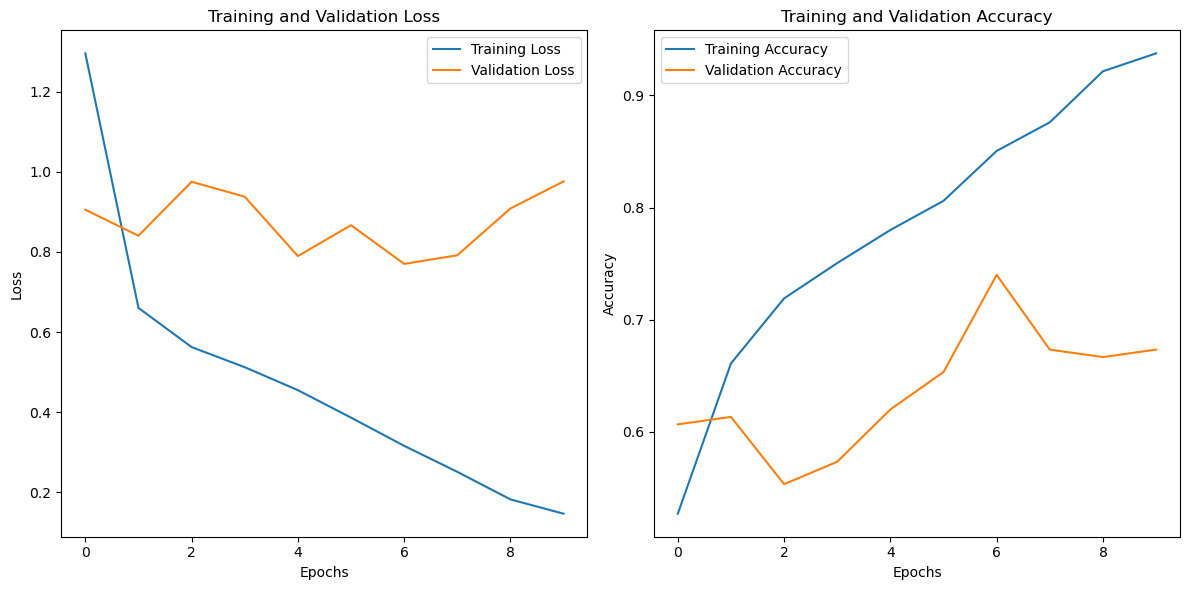

In [58]:
# Curva de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

Las gráficas muestran la función de pérdida (Loss) y la precisión (Accuracy) durante las épocas de entrenamiento en el conjunto entrenamiento y validación del modelo.

Aunque el modelo muestra mejoras en el conjunto de entrenamiento, el aumento de la función de pérdida de validación y la pequeña diferencia con la precisión de validación sugieren que hay sobreajuste. Veamos más en detalle cada gráfica: 

1) Gráfica de Pérdida (Loss):

    La función de pérdida de entrenamiento (curva azul) disminuye con el tiempo, lo que indica que el modelo está aprendiendo a reducir el error en el conjunto de entrenamiento.

    La función de pérdida de validación (curva naranja) aumenta en ciertas épocas, lo que puede ser un indicio de sobreajuste. Esto ocurre cuando el modelo empieza a ajustarse demasiado a los datos de entrenamiento y pierde capacidad para generalizar.

2) Gráfica de Precisión (Accuracy):

    La precisión de entrenamiento (curva azul) mejora a medida que avanzan las épocas, lo que sugiere que el modelo está aprendiendo correctamente a predecir las clases en el conjunto de entrenamiento.

    La precisión de validación (curva naranja) muestra un comportamiento algo similar, aunque con un aumento más moderado. La diferencia entre las precisiones de entrenamiento y validación puede indicar, al igual que en la gráfica anterior, que el modelo no está generalizando completamente bien.

In [59]:
# Evaluamos el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.5318 - loss: 1.5574
Test Loss: 1.0329476594924927
Test Accuracy: 0.675000011920929


Al aplicar el modelo para un conjunto nuevo, en este caso el de test, obtenemos unas métricas que no son muy buenas. Esto refuerza la conclusión anteriormente planteada de sobreajuste.

Después de entrenar las capas superiores, hacemos "fine-tuning" desbloqueando algunas capas del modelo base y entrenando nuevamente con una tasa de aprendizaje menor.

In [60]:
# Fine-tuning del modelo, desbloquear algunas capas y reentrenar
base_model.trainable = True
fine_tune_at = 100  # Elige en qué capa comenzará a entrenar

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar nuevamente con las capas desbloqueadas
model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 460s 7s/step - accuracy: 0.7708 - loss: 0.7362 - val_accuracy: 0.7133 - val_loss: 0.7860
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 369s 6s/step - accuracy: 0.9303 - loss: 0.1961 - val_accuracy: 0.7267 - val_loss: 0.7824
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 367s 6s/step - accuracy: 0.9834 - loss: 0.1012 - val_accuracy: 0.6800 - val_loss: 0.8514
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step - accuracy: 0.9924 - loss: 0.0721 - val_accuracy: 0.6867 - val_loss: 0.9064
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step - accuracy: 0.9994 - loss: 0.0438 - val_accuracy: 0.6933 - val_loss: 0.9666


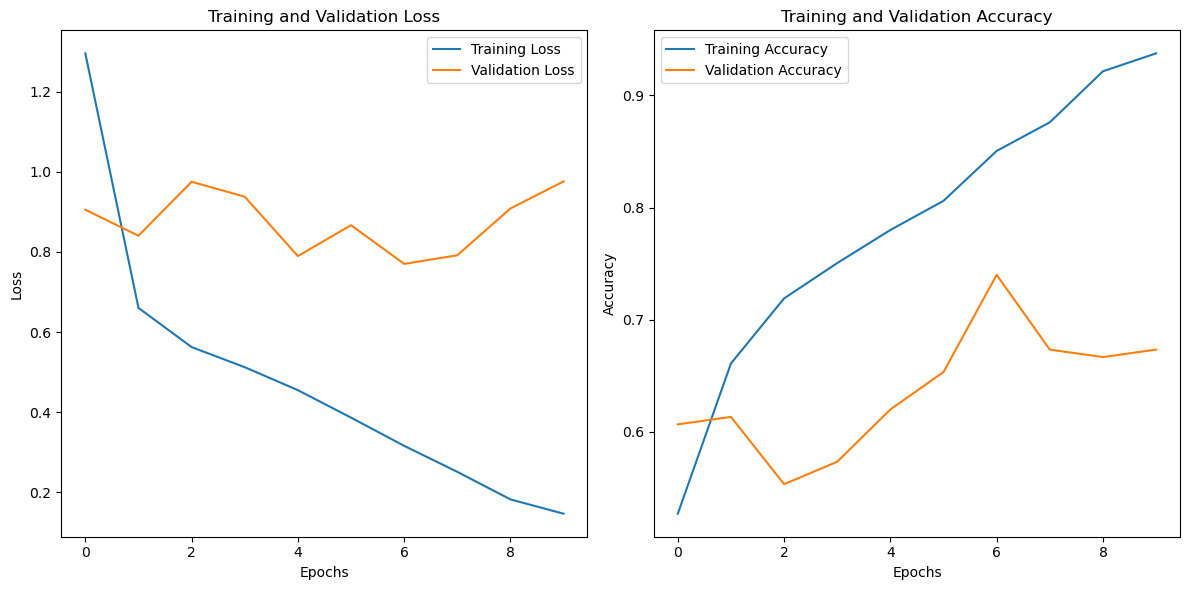

In [61]:
# Curva de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()